# Getting Started with PySGN

## Introduction to Geospatial Networks

Geospatial networks are a type of network where nodes are associated with specific geographic locations. These networks are used to model and analyze spatial relationships and interactions, such as transportation systems, communication networks, and social interactions within geographic constraints. By incorporating spatial data, geospatial networks provide insights into how location influences connectivity and network dynamics.

## Geospatial Erdős-Rényi, Watts-Strogatz & Barabási-Albert Networks

PySGN implements three popular models for generating synthetic geospatial networks: the Geospatial Erdős-Rényi model, the Geospatial Watts-Strogatz model, and the Geospatial Barabási-Albert model. All models are adaptations of classical network models that incorporate spatial considerations, allowing for the creation of networks that reflect real-world geographic constraints.

**Geospatial Erdős-Rényi Model:** This model is a variant of the classic Erdős-Rényi model, where each possible edge between nodes is connected with a probability that decreases with distance.

**Geospatial Watts-Strogatz Model:** This model extends the classic Watts-Strogatz model. Initially, each node is connected to its nearest neighbors, and edges are then rewired with a probability that depends on the distance between nodes.

**Geospatial Barabási-Albert Model:** This model is based on the classic Barabási–Albert model by combining preferential attachment with geographic distances. In this geospatial version, new nodes are added sequentially based on their proximity to the already placed nodes, and each new node attaches to existing nodes with a probability that increases with the target node’s degree while decreasing with distance.

By using these models, PySGN enables users to generate synthetic geospatial networks that capture the spatial characteristics and connectivity patterns of real-world systems.

## Installation and Setup

To get started with PySGN, you can install it using pip. This will also install its dependencies, such as NetworkX and GeoPandas.

```bash
pip install pysgn
```

Let's import everything we need, and define functions to be used later:

In [1]:
import random
import statistics
from collections import Counter

import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib_inline
import networkx as nx
import numpy as np
import pandas as pd
from IPython.display import Image
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point

from pysgn import (
    geo_barabasi_albert_network,
    geo_erdos_renyi_network,
    geo_watts_strogatz_network,
)
from pysgn.ordering import attribute_order, density_order, random_order

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")


def plot_degree_distribution(graph, ax=None):
    degree_sequence = sorted([d for _, d in graph.degree()], reverse=True)
    degree_count = Counter(degree_sequence)
    deg, cnt = zip(*degree_count.items())
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 8))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlim([-0.5, max(degree_sequence) + 1.5])
    ax.bar(deg, cnt, width=0.80, color="#43a2ca")
    ax.set_title(
        f"Network Degree Histogram ({graph.number_of_nodes():,} nodes)\n(mean={np.mean(degree_sequence):.1f}, std={np.std(degree_sequence):.2f}, mode={statistics.mode(degree_sequence)})",
    )
    ax.set_ylabel("Count")
    ax.set_xlabel("Degree")

# Example: Geospatial Erdős-Rényi Network

To begin with, let us first create a synthetic dataset of random points:

<Axes: >

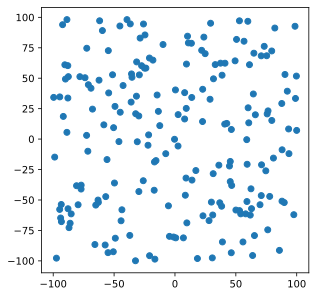

In [2]:
num_points = 200
x_coords = np.random.uniform(-100, 100, num_points)
y_coords = np.random.uniform(-100, 100, num_points)
points = [Point(x, y) for x, y in zip(x_coords, y_coords)]

gdf = gpd.GeoDataFrame(pd.DataFrame({"geometry": points}), crs="EPSG:3857")

gdf.plot()

The geospatial Erdős-Rényi network is a good place to start with if you don't know much about how the resulting network should look like. It can be created by simply using the `geo_erdos_renyi_network` function:

In [3]:
graph = geo_erdos_renyi_network(gdf)

The result can be visualized using NetworkX and Matplotlib:

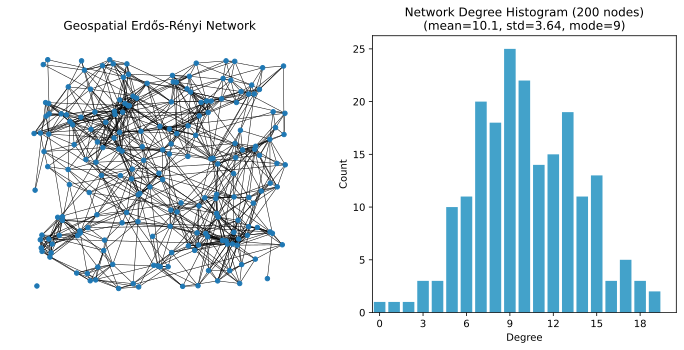

In [4]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
nx.draw(
    graph, pos=nx.get_node_attributes(graph, "pos"), node_size=20, width=0.5, ax=ax[0]
)
ax[0].set_title("Geospatial Erdős-Rényi Network")
plot_degree_distribution(graph, ax=ax[1])

The Geospatial Erdős-Rényi model is a variant of the Erdős-Rényi model that incorporates spatial considerations. Each possible edge in the network is connected with probability:

$$
  p(d|a, \textrm{min_dist}) = \textrm{min}\left(1, \left(\frac{d}{\textrm{min_dist}}\right) ^ {-a}\right)
$$

where `d` is edge length, `min_dist` is the minimum edge length, and `a` is the distance decay exponent parameter, default is 3.

The minimum length is a threshold, below which edges are created with probability 1. It is 1/20 of the bounding box diagonal by default. Users can set the `scaling_factor` parameter if needed, which is the inverse of the minimum length.

In summary, the probability of two nodes being connected decays exponentially with respect to their distance. Conversely, if two nodes are too close with a distance smaller than `1/scaling_factor`, then they are always connected.

The probability decay function, parameterized by `a` and `scaling_factor`, looks like the following:

In [ ]:
def connection_probability(
    distance: np.ndarray, a: float, scaling_factor: float
) -> np.ndarray:
    # Replace zero with a small number to avoid division by zero
    distance[distance == 0.0] = 1e-6
    min_dist = 1 / scaling_factor
    return np.minimum(1, (distance / min_dist) ** -a)


distances = np.linspace(0, 10, 500)
a_values = [1, 2, 3, 4]
scaling_factors = [0.1, 0.2, 0.5]

fig, axes = plt.subplots(
    1, len(scaling_factors), figsize=(15, 5), sharex=True, sharey=True
)

for j, scaling_factor in enumerate(scaling_factors):
    for a in a_values:
        probabilities = connection_probability(distances, a, scaling_factor)
        axes[j].plot(distances, probabilities, label=f"a={a}")
    axes[j].set_title(
        f"scaling_factor={scaling_factor}\n(min_dist={1/scaling_factor})", fontsize=22
    )
    axes[j].set_xlabel("Distance", fontsize=20)
    axes[j].grid(True, linestyle="--")
    axes[j].tick_params(axis="both", which="major", labelsize=20)

axes[0].set_ylabel("Probability", fontsize=20)
lines, labels = axes[0].get_legend_handles_labels()
fig.legend(
    lines, labels, loc="upper left", bbox_to_anchor=(1.0, 0.87), prop={"size": 20}
)

plt.tight_layout()

# Example: Geospatial Watts-Strogatz Network

The geospatial Watts-Strogatz network provides more control on the resulting network, by allowing two more parameters:

- `k` (int or str): The number of nearest neighbors each node is initially connected to.
    * If an integer, it specifies the initial number of neighbors for all nodes. The resulting network has a mean degree of `k`.
    * If a string, it refers to a column in the GeoDataFrame that contains the expected degree centrality for each node.
- `p` (float): The probability of rewiring each edge. This parameter controls the randomness of the network. A value of 0 results in a regular lattice, while a value of 1 results in a random network.

First, the model connects each node to its `k` nearest neighbors.

Then, it rewires each edge with probability `p`. When an edge is rewired, it is removed and a new edge is added to a random node.
The probability of being rewired to a new node is determined by the distance between the nodes:
$$
  p(d|a, \textrm{min_dist}) = \textrm{min}\left(1, \left(\frac{d}{\textrm{min_dist}}\right) ^ {-a}\right)
$$
where `d` is edge length, `min_dist` is the minimum edge length, and `a` is the distance decay exponent parameter, default is 3.

This decay function of probabilities with respect to node distance works the same as above in the geospatial Erdős-Rényi network.

The effect of `k` and `p` parameters can be seen on the following grid example:

In [ ]:
x = np.linspace(0, 10, 5)
y = np.linspace(0, 10, 5)
xx, yy = np.meshgrid(x, y)
points = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(xx.flatten(), yy.flatten()), crs="EPSG:3857"
)


k_values = [2, 6]
p_values = [0, 0.1, 0.5]
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, k in enumerate(k_values):
    for j, p in enumerate(p_values):
        graph = geo_watts_strogatz_network(
            points, k=k, p=p, a=3, scaling_factor=0.05, random_state=42, verbose=False
        )
        ax = axes[i, j]
        pos = nx.get_node_attributes(graph, "pos")
        nx.draw(graph, pos=pos, node_size=50, ax=ax, with_labels=False)
        if p == 0:
            title = f"Local Connections Only: p={p}"
        elif p == 0.1:
            title = f"With Rewiring: p={p}"
        else:
            title = f"More Rewiring: p={p}"

        ax.set_title(f"\n{title}\n(k={k})", fontsize=22)

plt.tight_layout()

Using the method on the point synthetic data:

In [ ]:
graph = geo_watts_strogatz_network(gdf, k=6, p=0.3)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
nx.draw(
    graph, pos=nx.get_node_attributes(graph, "pos"), node_size=20, width=0.5, ax=ax[0]
)
ax[0].set_title("Geospatial Watts-Strogatz Network")
plot_degree_distribution(graph, ax=ax[1])

As we can see, the average degree centrality is 6, the same as our `k` parameter.

Instead of setting a global `k` parameter for the average degree centrality of all nodes, it is possible to specify each node's expected degree individually. In this case, the `k` parameter can be set to the column name containing such information.

For instance, you may want to generate a synthetic geospatial network to represent people's social connections. From certain studies, you find out that people live in certain areas in general have higher degrees than those who live in other areas. Hence, you want to create a synthetic geospatial network that captures this information.

This is illustrated in the following example, where each node has an expected degree value based on its location.

In [ ]:
grid_size = 3
expected_degrees = np.array([[4, 4, 4], [4, 6, 4], [4, 6, 10]])


def assign_expected_degree(point, grid_size, expected_degrees):
    x, y = point.x + 100.0, point.y + 100.0
    grid_x = int(x // (200 / grid_size))
    grid_y = int(y // (200 / grid_size))
    return expected_degrees[grid_size - grid_y - 1, grid_x]


gdf["expected_degree"] = gdf.geometry.apply(
    assign_expected_degree, args=(grid_size, expected_degrees)
)

gdf.head()

In [ ]:
_, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
gdf.plot(
    column="expected_degree",
    cmap="viridis_r",
    legend=True,
    cax=cax,
    legend_kwds={"label": "expected_degree", "orientation": "horizontal"},
    ax=ax,
)
ax.set_title("Synthetic point data with expected degree")

We can then set `k` to be the `expected_degree` column:

In [ ]:
graph = geo_watts_strogatz_network(gdf, k="expected_degree", p=0.3)

degrees = dict(graph.degree())
cmap = plt.colormaps.get_cmap("viridis_r")
node_colors = [cmap(degree / max(degrees.values())) for node, degree in degrees.items()]

_, ax = plt.subplots(1, 2, figsize=(10, 5))
nx.draw(
    graph,
    pos=nx.get_node_attributes(graph, "pos"),
    node_color=node_colors,
    node_size=20,
    width=0.5,
    ax=ax[0],
)
ax[0].set_title("Geospatial Watts-Strogatz Network")
plot_degree_distribution(graph, ax=ax[1])

As a result, nodes in the lower right corner have higher degrees (i.e., more connections) than nodes in other areas.

# Example: Geospatial Barabási-Albert Network

The geospatial Barabási-Albert network model combines preferential attachment with spatial constraints. In the original Barabási-Albert model, new nodes are more likely to connect to existing nodes with high degrees, leading to a "rich-get-richer" effect and a scale-free network structure.

In the geospatial variant, the probability of connection is influenced by both the node's degree and its geographic distance:

$$
  P(i) \propto k_i \cdot \textrm{min}\left(1, \left(\frac{\textrm{distance}}{\textrm{min_dist}}\right) ^ {-a}\right)
$$

where:
- $k_i$ is the degree of existing node i
- $\textrm{distance}$ is the geographic distance between existing node i and the new node
- $\textrm{min_dist}$ is the minimum distance threshold (1/scaling_factor)
- $a$ is the distance decay exponent parameter

The model has several key parameters:
- `m` (int): Number of edges to attach from a new node to existing nodes (and size of the seed network).
- `node_order` (callable or str): Order in which nodes are added to the network
- `a` (int): Distance decay exponent, controlling how strongly distance affects connection probability
- `scaling_factor` (float): Inverse of minimum distance threshold

Distance decay exponent `a` and parameter `scaling_factor` work the same as above in the geospatial Erdős-Rényi and Watts-Strogatz networks.

The `node_order` parameter controls the order in which nodes are added to the network. By default, nodes are added sequentially as they appear in the GeoDataFrame (first row is added first, second row is added second, and so on), but users can specify different ordering strategies:

- random order
- attribute order: Order by values in specific column(s) in ascending order
- density order (KNN or KDE): Order by spatial density (high to low)
- custom function: User-defined function that takes a GeoDataFrame and returns an order array

The sequence in which nodes join the network impacts the final structure. Early nodes typically become hubs with higher connectivity. Our implementation provides flexible ordering strategies based on spatial patterns, attributes, or custom logic. The choice of ordering strategy allows modeling various real-world network growth processes, such as urban expansion from dense centers or infrastructure development based on population needs.

Now let's create geospatial Barabási-Albert networks using the following synthetic data:

In [ ]:
# Create a synthetic point dataset
n_points = 100

# Generate clustered points
cluster1 = np.random.normal(loc=[3, 3], scale=[1, 1], size=(n_points // 2, 2))
cluster2 = np.random.normal(loc=[7, 7], scale=[1, 1], size=(n_points // 2, 2))
points = np.vstack([cluster1, cluster2])

# Create GeoDataFrame
geometries = [Point(x, y) for x, y in points]
utility = np.random.randint(100, 10000, size=n_points)
data = {"utility": utility, "geometry": geometries}
gdf = gpd.GeoDataFrame(data)

gdf.head()

In [ ]:
_, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
gdf.plot(
    column="utility",
    legend=True,
    cmap="viridis_r",
    cax=cax,
    legend_kwds={"label": "utility", "orientation": "horizontal"},
    ax=ax,
)
ax.set_title("Synthetic point data with random utility")

Let's visualize different node orderings:

In [ ]:
# Apply different ordering strategies
random_idx = random_order(gdf, random_state=42)
utility_idx = attribute_order(gdf, "utility")
density_knn_idx = density_order(gdf, method="knn", k=5)
density_kde_idx = density_order(gdf, method="kde", bandwidth=0.5)

# Visualize different orderings
fig, axs = plt.subplots(2, 2, figsize=(13, 10))
titles = [
    "Random Order",
    "Attribute Order ('utility' column)",
    "Density Order (KNN)",
    "Density Order (KDE)",
]
orders = [random_idx, utility_idx, density_knn_idx, density_kde_idx]

for i, (ax, title, order) in enumerate(zip(axs.flatten(), titles, orders)):
    # Get ordered positions
    x, y = points[order, 0], points[order, 1]

    # Plot points with color gradient showing order
    scatter = ax.scatter(x, y, c=np.arange(len(x)), cmap="viridis", s=80, alpha=0.8)

    ax.set_title(title)
    ax.set_aspect("equal")

fig.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.8, 0.055, 0.02, 0.9])
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label("Node Addition Order")

We can create synthetic networks using each ordering strategy and compare the results.

In [ ]:
ordering_functions = [
    lambda gdf: random_order(gdf, random_state=42),
    lambda gdf: attribute_order(gdf, "utility"),
    lambda gdf: density_order(gdf, method="knn", k=5),
    lambda gdf: density_order(gdf, method="kde", bandwidth=0.5),
]

fig, axs = plt.subplots(2, 4, figsize=(18, 8))
for i, (title, order) in enumerate(zip(titles, ordering_functions)):
    graph = geo_barabasi_albert_network(
        gdf,
        m=2,
        node_order=order,
        random_state=42,
    )
    degrees = dict(graph.degree())
    cmap = plt.colormaps.get_cmap("viridis_r")
    node_colors = [
        cmap(degree / max(degrees.values())) for node, degree in degrees.items()
    ]
    nx.draw(
        graph,
        pos=nx.get_node_attributes(graph, "pos"),
        node_color=node_colors,
        node_size=50,
        width=0.5,
        ax=axs[0, i],
        alpha=0.8,
    )
    axs[0, i].set_title(title)
    axs[0, i].set_aspect("equal")
    plot_degree_distribution(graph, axs[1, i])

The degree distribution plots show the characteristic power-law behavior of Barabási-Albert networks. The spatial constraints modify this pure power-law behavior, as geographic distance limits the potential connections. However, the network still maintains the general scale-free property, where a few hub nodes have many connections while most nodes have relatively few.

This model is particularly useful for modeling networks where:
1. The network grows over time
2. New nodes preferentially attach to well-connected nodes
3. Geographic distance influences connection probability
4. A scale-free degree distribution is expected

Examples include transportation networks, power grids, and some types of social networks where both popularity and proximity affect connection patterns.

# More Options

## Including Node Attributes

When generating a network, you can choose to include node attributes from your GeoDataFrame. This is done using the `node_attributes` parameter in PySGN functions. You can specify:

- `True`: To include all variables from the GeoDataFrame as node attributes. This is the default behavior.
- A string or list of strings: To include only specific attributes by their column names.
- `False`: Only the position of the nodes will be saved as a `pos` attribute in the network.

Including node attributes allows you to leverage additional data in your network analysis, such as demographic information, geographic features, or any other relevant metadata.

Imagine our point synthetic data are of different groups:

In [ ]:
gdf["group"] = random.choices(["Group A", "Group B"], k=len(gdf))
gdf.head()

By default, PySGN functions keep all variables from the GeoDataFrame as node attributes:

In [ ]:
graph = geo_erdos_renyi_network(gdf)

groups = nx.get_node_attributes(graph, "group")
colors = {"Group A": "tab:blue", "Group B": "tab:orange"}
node_colors = [colors[groups[node]] for node in graph.nodes]
nx.draw(
    graph,
    pos=nx.get_node_attributes(graph, "pos"),
    node_color=node_colors,
    node_size=20,
    width=0.5,
)
legend_handles = [
    mpatches.Patch(color=color, label=group) for group, color in colors.items()
]
plt.legend(
    handles=legend_handles, title="Groups", loc="upper right", bbox_to_anchor=[1.1, 1.0]
)
plt.title("Geospatial Erdős-Rényi Network")

You may turn this off by setting `node_attributes=False`, or providing the column names that should be included in the network:

```python
# saving only a `pos` node attribute
geo_erdos_renyi_network(gdf, node_attributes=False)

# each node has `pos` and `group` attributes
geo_erdos_renyi_network(gdf, node_attributes="group")

# each node has `pos`, `group`, and `some_other_col` attributes
geo_erdos_renyi_network(gdf, node_attributes=["group", "some_other_col"])
```

This works with the `geo_watts_strogatz_network` method too.

## Custom Constraints

Custom constraints allow you to impose specific rules on the connections between nodes in your network. This can be useful for modeling real-world scenarios where certain connections are only possible under specific conditions.

In PySGN, you can define a custom constraint function that takes two nodes as input and returns a boolean value indicating whether an edge should be created between them. This function can be passed to the network generation method using the `constraint` parameter.

As an example, we'll use the `group` attribute in the gdf to create a custom constraint that only allows edges between nodes from the same group.

In [ ]:
graph = geo_watts_strogatz_network(
    gdf, k=4, p=0.3, constraint=lambda u, v: u.group == v.group
)

groups = nx.get_node_attributes(graph, "group")
colors = {"Group A": "tab:blue", "Group B": "tab:orange"}
node_colors = [colors[groups[node]] for node in graph.nodes]
edge_colors = [colors[groups[edge[0]]] for edge in graph.edges]
nx.draw(
    graph,
    pos=nx.get_node_attributes(graph, "pos"),
    node_color=node_colors,
    edge_color=edge_colors,
    node_size=20,
    width=0.5,
)
legend_handles = [
    mpatches.Patch(color=color, label=group) for group, color in colors.items()
]
plt.legend(
    handles=legend_handles, title="Groups", loc="upper right", bbox_to_anchor=[1.1, 1.0]
)
plt.title("Geospatial Watts-Strogatz Network")

Conversely, if you want nodes to be connected to nodes of different group only:

In [ ]:
graph = geo_watts_strogatz_network(
    gdf, k=4, p=0.3, constraint=lambda u, v: u.group != v.group
)

groups = nx.get_node_attributes(graph, "group")
colors = {"Group A": "tab:blue", "Group B": "tab:orange"}
node_colors = [colors[groups[node]] for node in graph.nodes]
nx.draw(
    graph,
    pos=nx.get_node_attributes(graph, "pos"),
    node_color=node_colors,
    node_size=20,
    width=0.5,
)
legend_handles = [
    mpatches.Patch(color=color, label=group) for group, color in colors.items()
]
plt.legend(
    handles=legend_handles, title="Groups", loc="upper right", bbox_to_anchor=[1.1, 1.0]
)
plt.title("Geospatial Watts-Strogatz Network")

# Performance

We measure and visualize the time and space complexities of our synthetic network models as they scale with different numbers of nodes. This helps understand how computational resources scale with network size.

Note that performance can vary significantly depending on the specific parameters (e.g., distance decay exponent, scaling factor, `k`, `m`, and so on) used in your network models. Here we set `m=10` for geospatial Barabási-Albert network and `k=10`, `p=0.1` for geospatial Watts-Strogatz network, with all other parameters using their default values.

**Hardware Specifications**

The results are based on the hardware this notebook is currently running on, with Python 3.13.2:

- CPU: 2.6 GHz 6-Core Intel Core i7
- Memory: 16 GB 2667 MHz DDR4
- Operating System: macOS Sequoia 15.3.2

In [ ]:
Image("perf.png")

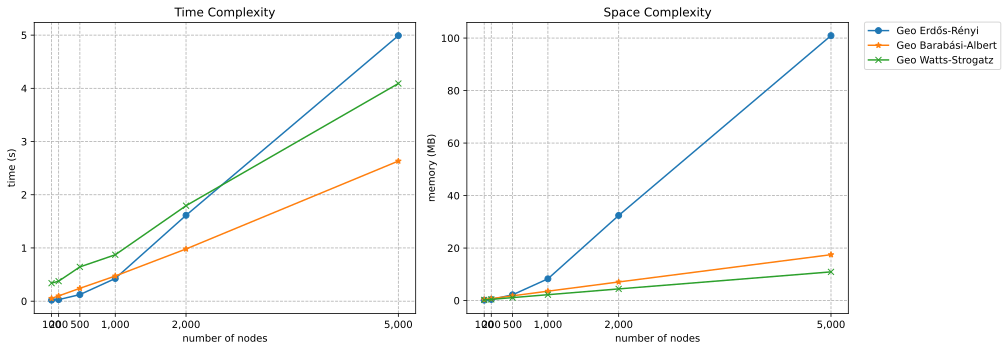

In [7]:
import time
import tracemalloc

from matplotlib import ticker

num_points = 10000
x_coords = np.random.uniform(-5000, 5000, num_points)
y_coords = np.random.uniform(-5000, 5000, num_points)
points = [Point(x, y) for x, y in zip(x_coords, y_coords)]
points_gdf = gpd.GeoDataFrame(pd.DataFrame({"geometry": points}), crs="EPSG:3857")
gdf_list = [
    points_gdf.sample(n=n, replace=False, random_state=42)
    # for n in [100, 1000, 2000, 5000, 8000, 10000]
    for n in [100, 200, 500, 1000, 2000, 5000]
]

perf = {
    "num_nodes": [],
    "time_s": [],
    "memory_mb": [],
    "model": [],
}
for gdf in gdf_list:
    for (
        model,
        func,
        params,
    ) in zip(
        ["Geo Erdős-Rényi", "Geo Barabási-Albert", "Geo Watts-Strogatz"],
        [
            geo_erdos_renyi_network,
            geo_barabasi_albert_network,
            geo_watts_strogatz_network,
        ],
        [{}, {"m": 10}, {"k": 10, "p": 0.1}],
    ):
        perf["num_nodes"].append(len(gdf))
        perf["model"].append(model)
        tracemalloc.start()
        start_time = time.perf_counter()
        _ = func(gdf, **params)
        elapsed = time.perf_counter() - start_time
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        perf["time_s"].append(elapsed)
        perf["memory_mb"].append(peak / 1024**2)

perf_df = pd.DataFrame(perf)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for color, model, marker in zip(
    ["tab:blue", "tab:orange", "tab:green"],
    ["Geo Erdős-Rényi", "Geo Barabási-Albert", "Geo Watts-Strogatz"],
    ["o", "*", "x"],
):
    ax[0].plot(
        perf_df.loc[perf_df["model"] == model, "num_nodes"],
        perf_df.loc[perf_df["model"] == model, "time_s"],
        color=color,
        marker=marker,
        label=model,
    )
    ax[0].grid(True, linestyle="--")
    ax[1].plot(
        perf_df.loc[perf_df["model"] == model, "num_nodes"],
        perf_df.loc[perf_df["model"] == model, "memory_mb"],
        color=color,
        marker=marker,
        label=model,
    )
    ax[1].grid(True, linestyle="--")

ax[0].set_xticks(perf_df.loc[perf_df["model"] == model, "num_nodes"])
ax[0].set_xlabel("number of nodes")
ax[0].set_ylabel("time (s)")
ax[0].set_title("Time Complexity")
ax[0].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

ax[1].set_xticks(perf_df.loc[perf_df["model"] == model, "num_nodes"])
ax[1].set_xlabel("number of nodes")
ax[1].set_ylabel("memory (MB)")
ax[1].set_title("Space Complexity")
ax[1].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
lines, labels = ax[1].get_legend_handles_labels()
fig.legend(lines, labels, loc="upper left", bbox_to_anchor=(1.0, 0.94))
fig.tight_layout()

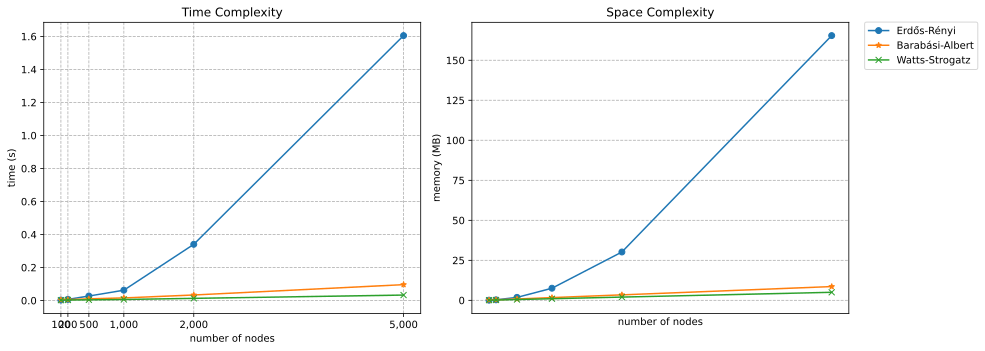

In [11]:
import time
import tracemalloc

from matplotlib import ticker
from networkx import barabasi_albert_graph, erdos_renyi_graph, watts_strogatz_graph

n_list = [100, 200, 500, 1000, 2000, 5000]

perf_nx = {
    "num_nodes": [],
    "time_s": [],
    "memory_mb": [],
    "model": [],
}
for n in n_list:
    for (
        model,
        func,
        params,
    ) in zip(
        ["Erdős-Rényi", "Barabási-Albert", "Watts-Strogatz"],
        [
            erdos_renyi_graph,
            barabasi_albert_graph,
            watts_strogatz_graph,
        ],
        [{"p": 0.1}, {"m": 10}, {"k": 10, "p": 0.1}],
    ):
        perf_nx["num_nodes"].append(n)
        perf_nx["model"].append(model)
        tracemalloc.start()
        start_time = time.perf_counter()
        _ = func(n, **params)
        elapsed = time.perf_counter() - start_time
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        perf_nx["time_s"].append(elapsed)
        perf_nx["memory_mb"].append(peak / 1024**2)

perf_nx_df = pd.DataFrame(perf_nx)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for color, model, marker in zip(
    ["tab:blue", "tab:orange", "tab:green"],
    ["Erdős-Rényi", "Barabási-Albert", "Watts-Strogatz"],
    ["o", "*", "x"],
):
    ax[0].plot(
        perf_nx_df.loc[perf_nx_df["model"] == model, "num_nodes"],
        perf_nx_df.loc[perf_nx_df["model"] == model, "time_s"],
        color=color,
        marker=marker,
        label=model,
    )
    ax[0].grid(True, linestyle="--")
    ax[1].plot(
        perf_nx_df.loc[perf_nx_df["model"] == model, "num_nodes"],
        perf_nx_df.loc[perf_nx_df["model"] == model, "memory_mb"],
        color=color,
        marker=marker,
        label=model,
    )
    ax[1].grid(True, linestyle="--")

ax[0].set_xticks(perf_nx_df.loc[perf_nx_df["model"] == model, "num_nodes"])
ax[0].set_xlabel("number of nodes")
ax[0].set_ylabel("time (s)")
ax[0].set_title("Time Complexity")
ax[0].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

ax[1].set_xticks(perf_nx_df.loc[perf_df["model"] == model, "num_nodes"])
ax[1].set_xlabel("number of nodes")
ax[1].set_ylabel("memory (MB)")
ax[1].set_title("Space Complexity")
ax[1].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
lines, labels = ax[1].get_legend_handles_labels()
fig.legend(lines, labels, loc="upper left", bbox_to_anchor=(1.0, 0.94))
fig.tight_layout()

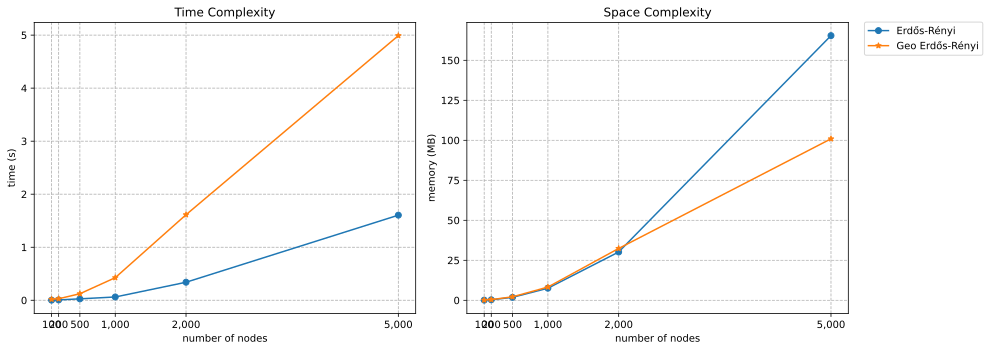

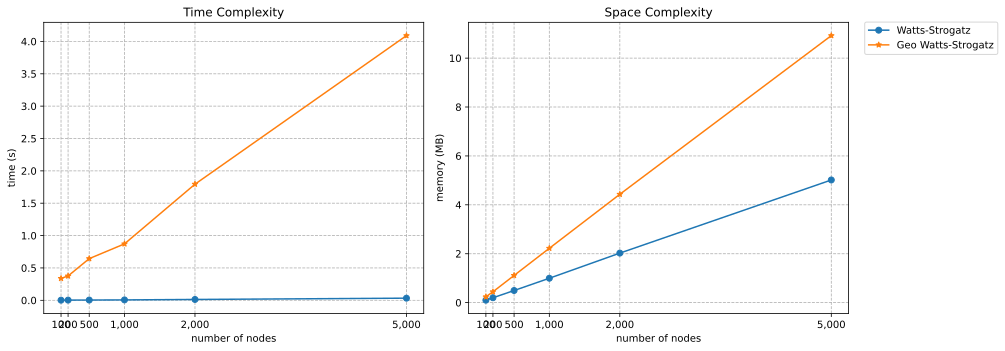

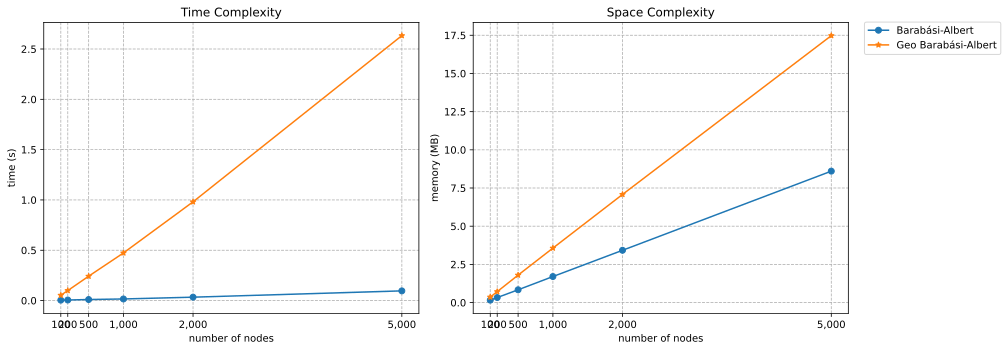

In [19]:
for nx_model, geo_model in [
    ("Erdős-Rényi", "Geo Erdős-Rényi"),
    ("Watts-Strogatz", "Geo Watts-Strogatz"),
    ("Barabási-Albert", "Geo Barabási-Albert"),
]:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(
        perf_nx_df.loc[perf_nx_df["model"] == nx_model, "num_nodes"],
        perf_nx_df.loc[perf_nx_df["model"] == nx_model, "time_s"],
        color="tab:blue",
        marker="o",
        label=nx_model,
    )
    ax[0].plot(
        perf_df.loc[perf_df["model"] == geo_model, "num_nodes"],
        perf_df.loc[perf_df["model"] == geo_model, "time_s"],
        color="tab:orange",
        marker="*",
        label=geo_model,
    )
    ax[0].grid(True, linestyle="--")
    ax[1].plot(
        perf_nx_df.loc[perf_nx_df["model"] == nx_model, "num_nodes"],
        perf_nx_df.loc[perf_nx_df["model"] == nx_model, "memory_mb"],
        color="tab:blue",
        marker="o",
        label=nx_model,
    )
    ax[1].plot(
        perf_df.loc[perf_df["model"] == geo_model, "num_nodes"],
        perf_df.loc[perf_df["model"] == geo_model, "memory_mb"],
        color="tab:orange",
        marker="*",
        label=geo_model,
    )
    ax[1].grid(True, linestyle="--")

    ax[0].set_xticks(perf_nx_df.loc[perf_nx_df["model"] == nx_model, "num_nodes"])
    ax[0].set_xlabel("number of nodes")
    ax[0].set_ylabel("time (s)")
    ax[0].set_title("Time Complexity")
    ax[0].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

    ax[1].set_xticks(perf_nx_df.loc[perf_nx_df["model"] == nx_model, "num_nodes"])
    ax[1].set_xlabel("number of nodes")
    ax[1].set_ylabel("memory (MB)")
    ax[1].set_title("Space Complexity")
    ax[1].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
    lines, labels = ax[1].get_legend_handles_labels()

    fig.legend(lines, labels, loc="upper left", bbox_to_anchor=(1.0, 0.94))
    fig.tight_layout()